#Анализ размера складских помещений магазина с применением метода кластеризации

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

df = pd.read_csv(".//static//csv//Stores.csv")

print(df.columns)

Index(['Store ID ', 'Store_Area', 'Items_Available', 'Daily_Customer_Count',
       'Store_Sales'],
      dtype='object')


In [30]:
df.head()

Store ID   Store_Area  Items_Available  Daily_Customer_Count  Store_Sales
0          1        1659             1961                   530        66490
1          2        1461             1752                   210        39820
2          3        1340             1609                   720        54010
3          4        1451             1748                   620        53730
4          5        1770             2111                   450        46620

In [31]:
df.describe()

Store ID    Store_Area  Items_Available  Daily_Customer_Count  \
count  896.000000   896.000000       896.000000            896.000000   
mean   448.500000  1485.409598      1782.035714            786.350446   
std    258.797218   250.237011       299.872053            265.389281   
min      1.000000   775.000000       932.000000             10.000000   
25%    224.750000  1316.750000      1575.500000            600.000000   
50%    448.500000  1477.000000      1773.500000            780.000000   
75%    672.250000  1653.500000      1982.750000            970.000000   
max    896.000000  2229.000000      2667.000000           1560.000000   

         Store_Sales  
count     896.000000  
mean    59351.305804  
std     17190.741895  
min     14920.000000  
25%     46530.000000  
50%     58605.000000  
75%     71872.500000  
max    116320.000000

In [32]:
# Процент пропущенных значений признаков
for i in df.columns:
    null_rate = df[i].isnull().sum() / len(df) * 100
    if null_rate > 0:
        print(f'{i} Процент пустых значений: %{null_rate:.2f}')

print(df.isnull().sum())

print(df.isnull().any())

Store ID                0
Store_Area              0
Items_Available         0
Daily_Customer_Count    0
Store_Sales             0
dtype: int64
Store ID                False
Store_Area              False
Items_Available         False
Daily_Customer_Count    False
Store_Sales             False
dtype: bool


In [33]:
# Проверка типов столбцов
df.dtypes

Store ID                int64
Store_Area              int64
Items_Available         int64
Daily_Customer_Count    int64
Store_Sales             int64
dtype: object

# Атрибуты  

id: уникальный идентификатор магазина

Store_Area: физическая площадь магазина на площади ярда
Items_Available: количество различных товаров, доступных в соответствующем магазине.
Daily_Customer_Count: количество клиентов, посетивших магазины в среднем за месяц.
Store_Sales: Продажи в (долларах США), произведенные магазинами.


**Цель:** Кластеризация магазинов на группы для определения схожих характеристик.  


## Очистка данных

In [34]:
# Удалим несущественные столбцы
columns_to_drop = ["Store ID "]
df_cleaned = df.drop(columns=columns_to_drop)

print(df_cleaned.head())  # Вывод очищенного DataFrame

   Store_Area  Items_Available  Daily_Customer_Count  Store_Sales
0        1659             1961                   530        66490
1        1461             1752                   210        39820
2        1340             1609                   720        54010
3        1451             1748                   620        53730
4        1770             2111                   450        46620


## Визуализация парных взаимосвязей

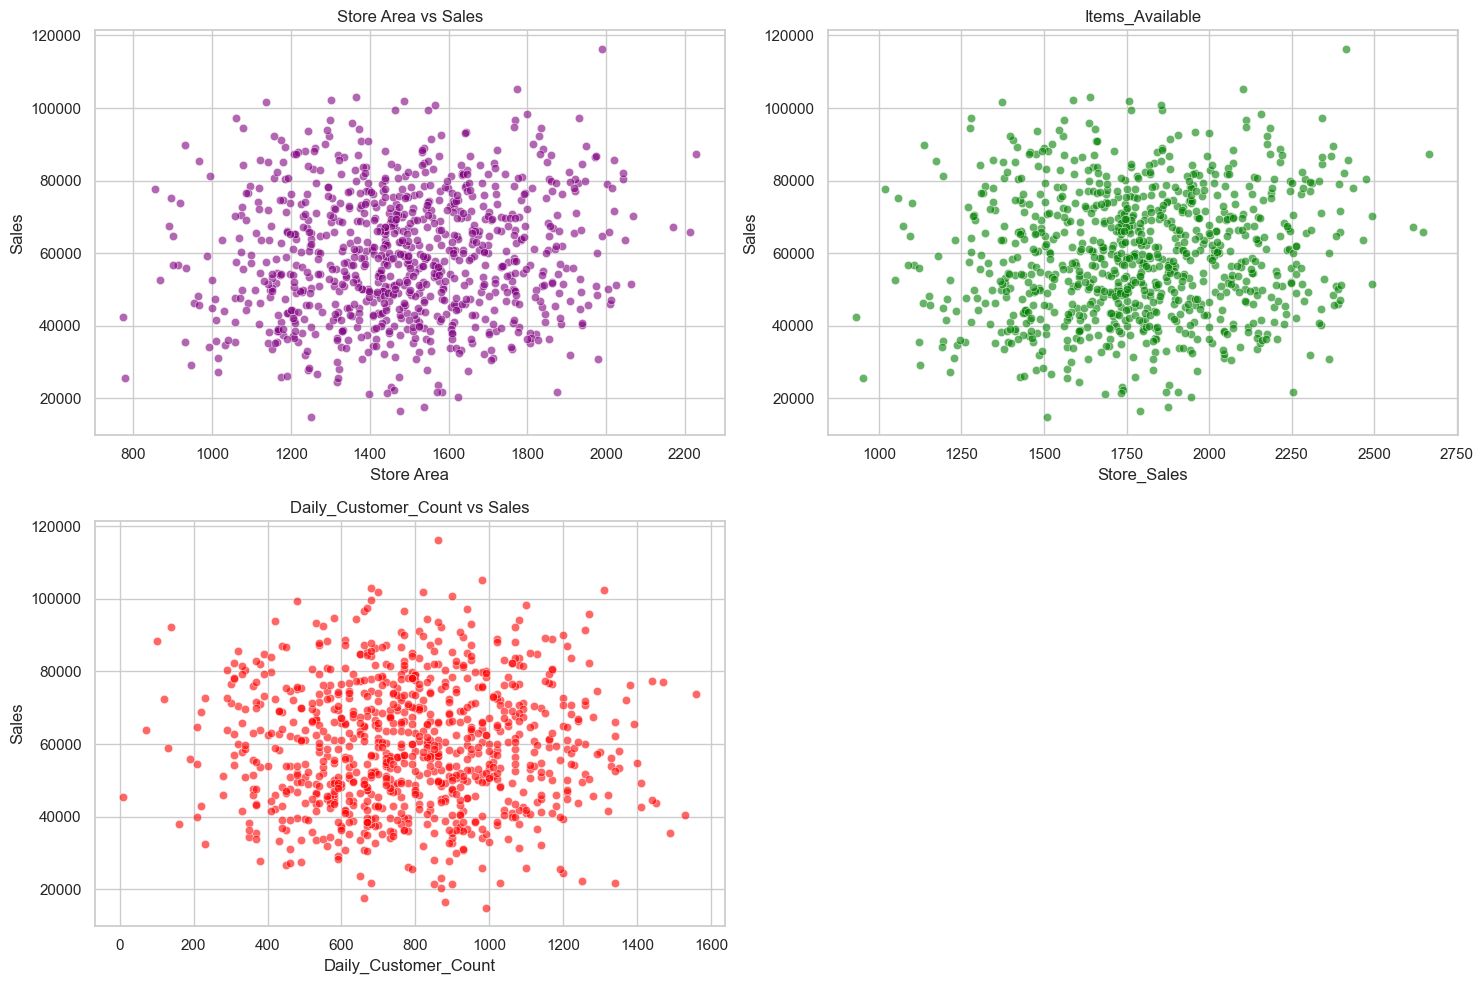

In [35]:
# Настройка стиля графиков
sns.set(style="whitegrid")

# Создание фигуры
plt.figure(figsize=(15, 10))

# График 1: Площадь vs Продажи
plt.subplot(2, 2, 1)
sns.scatterplot(
    x=df_cleaned["Store_Area"], y=df_cleaned["Store_Sales"], alpha=0.6, color="purple"
)
plt.title('Store Area vs Sales')
plt.xlabel('Store Area')
plt.ylabel('Sales')

# График 2: Количество ассортимента vs продажи
plt.subplot(2, 2, 2)
sns.scatterplot(
    x=df_cleaned["Items_Available"],
    y=df_cleaned["Store_Sales"],
    alpha=0.6,
    color="green",
)
plt.title("Items_Available")
plt.xlabel("Store_Sales")
plt.ylabel('Sales')

# График 3: Количество посетителей vs Цена
plt.subplot(2, 2, 3)
sns.scatterplot(
    x=df_cleaned["Daily_Customer_Count"], y=df_cleaned["Store_Sales"], alpha=0.6, color="red"
)
plt.title("Daily_Customer_Count vs Sales")
plt.xlabel("Daily_Customer_Count")
plt.ylabel('Sales')


# Упорядочиваем графики
plt.tight_layout()
plt.show()

### Стандартизация данных для кластеризации

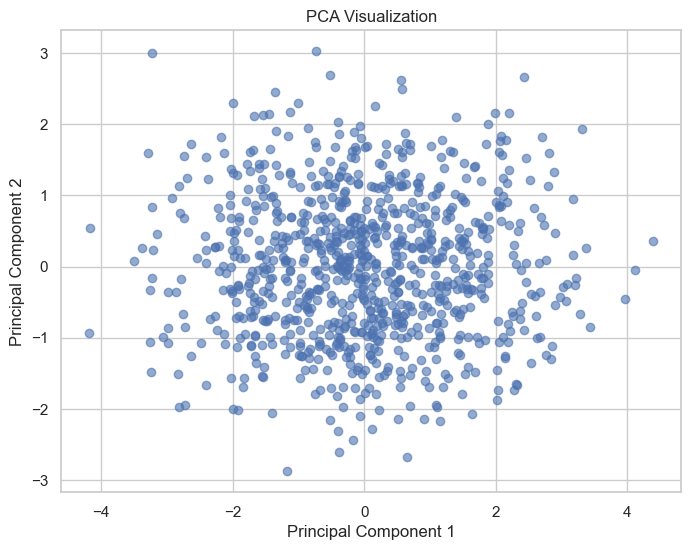

In [36]:
# Нормализация данных
scaler = StandardScaler()
data_scaled = scaler.fit_transform(df_cleaned)

# Преобразование в DataFrame для удобства
df_scaled = pd.DataFrame(data_scaled, columns=df_cleaned.columns)

# Понижение размерности до 2 компонент
pca = PCA(n_components=2)
kc_pca = pca.fit_transform(df_scaled)

# Визуализация
plt.figure(figsize=(8, 6))
plt.scatter(kc_pca[:, 0], kc_pca[:, 1], alpha=0.6)
plt.title("PCA Visualization")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()

### Агломеративная (иерархическая) кластеризация

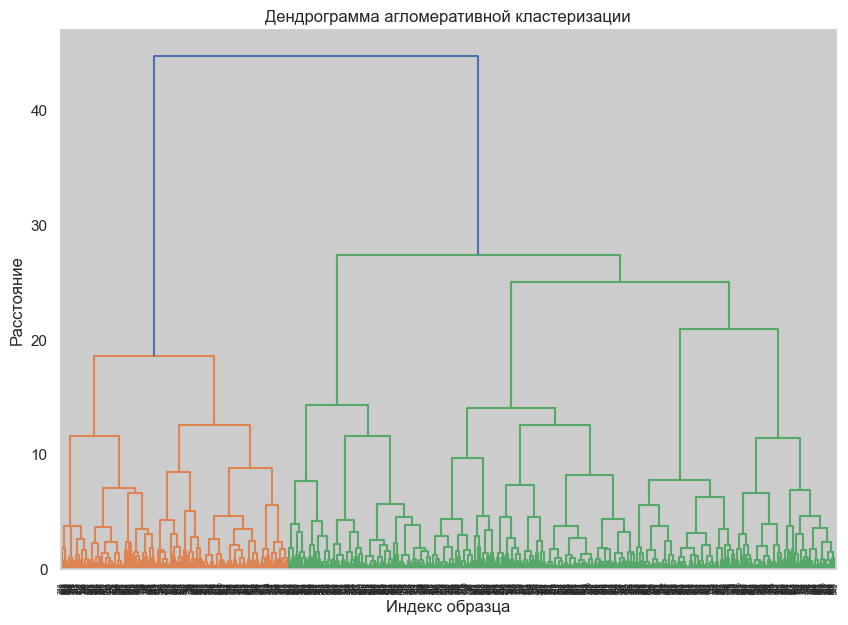

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 

In [37]:
# Построение дендрограммы
linkage_matrix = linkage(data_scaled, method='ward')
plt.figure(figsize=(10, 7))
dendrogram(linkage_matrix)
plt.title('Дендрограмма агломеративной кластеризации')
plt.xlabel('Индекс образца')
plt.ylabel('Расстояние')
plt.show()

# Получение результатов кластеризации с заданным порогом
result = fcluster(linkage_matrix, t=60, criterion='distance')
print(result)  # Вывод результатов кластеризации

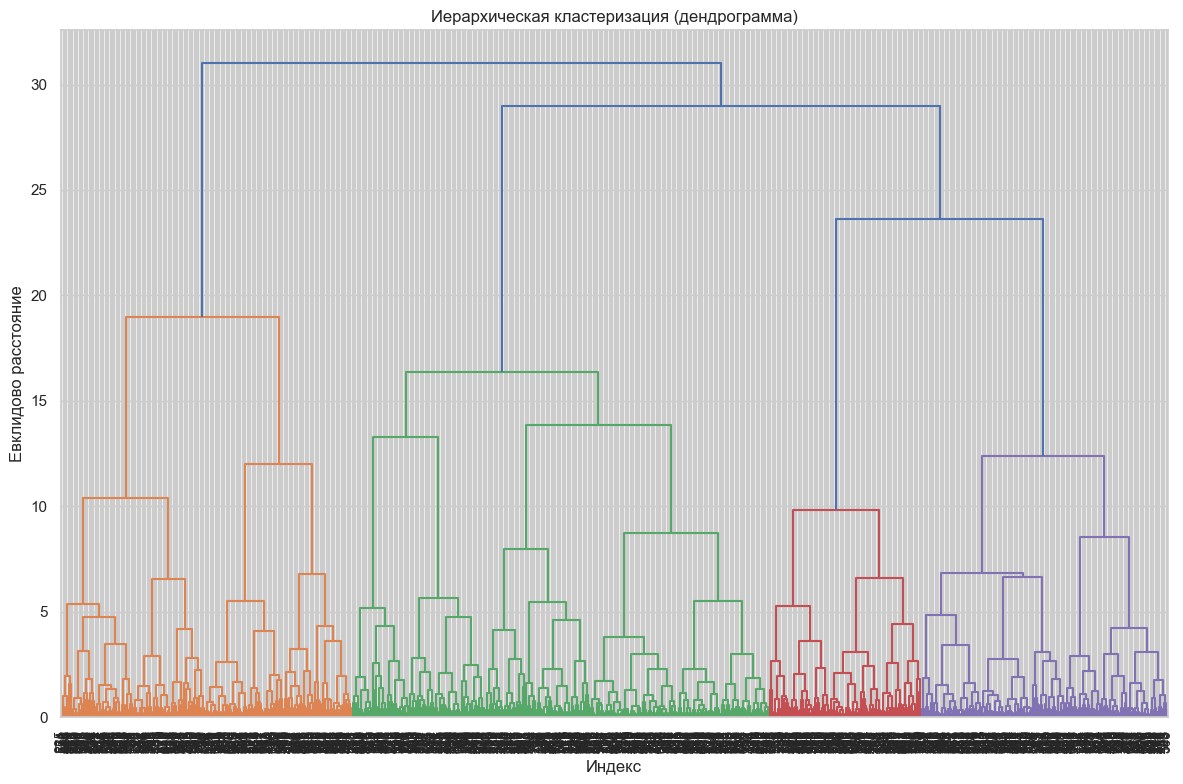

In [38]:
# Выбираем подмножество данных для кластеризации
features = df[["Store_Sales", "Store_Area", "Daily_Customer_Count"]]

scaled_features = scaler.fit_transform(features)

# Построение дендрограммы
linkage_matrix = linkage(scaled_features, method='ward')  # Метод "Ward"

plt.figure(figsize=(12, 8))
dendrogram(linkage_matrix, labels=df.index, leaf_rotation=90, leaf_font_size=10)
plt.title('Иерархическая кластеризация (дендрограмма)')
plt.xlabel('Индекс')
plt.ylabel('Евклидово расстояние')
plt.tight_layout()
plt.show()

**Визуализация распределения кластеров**

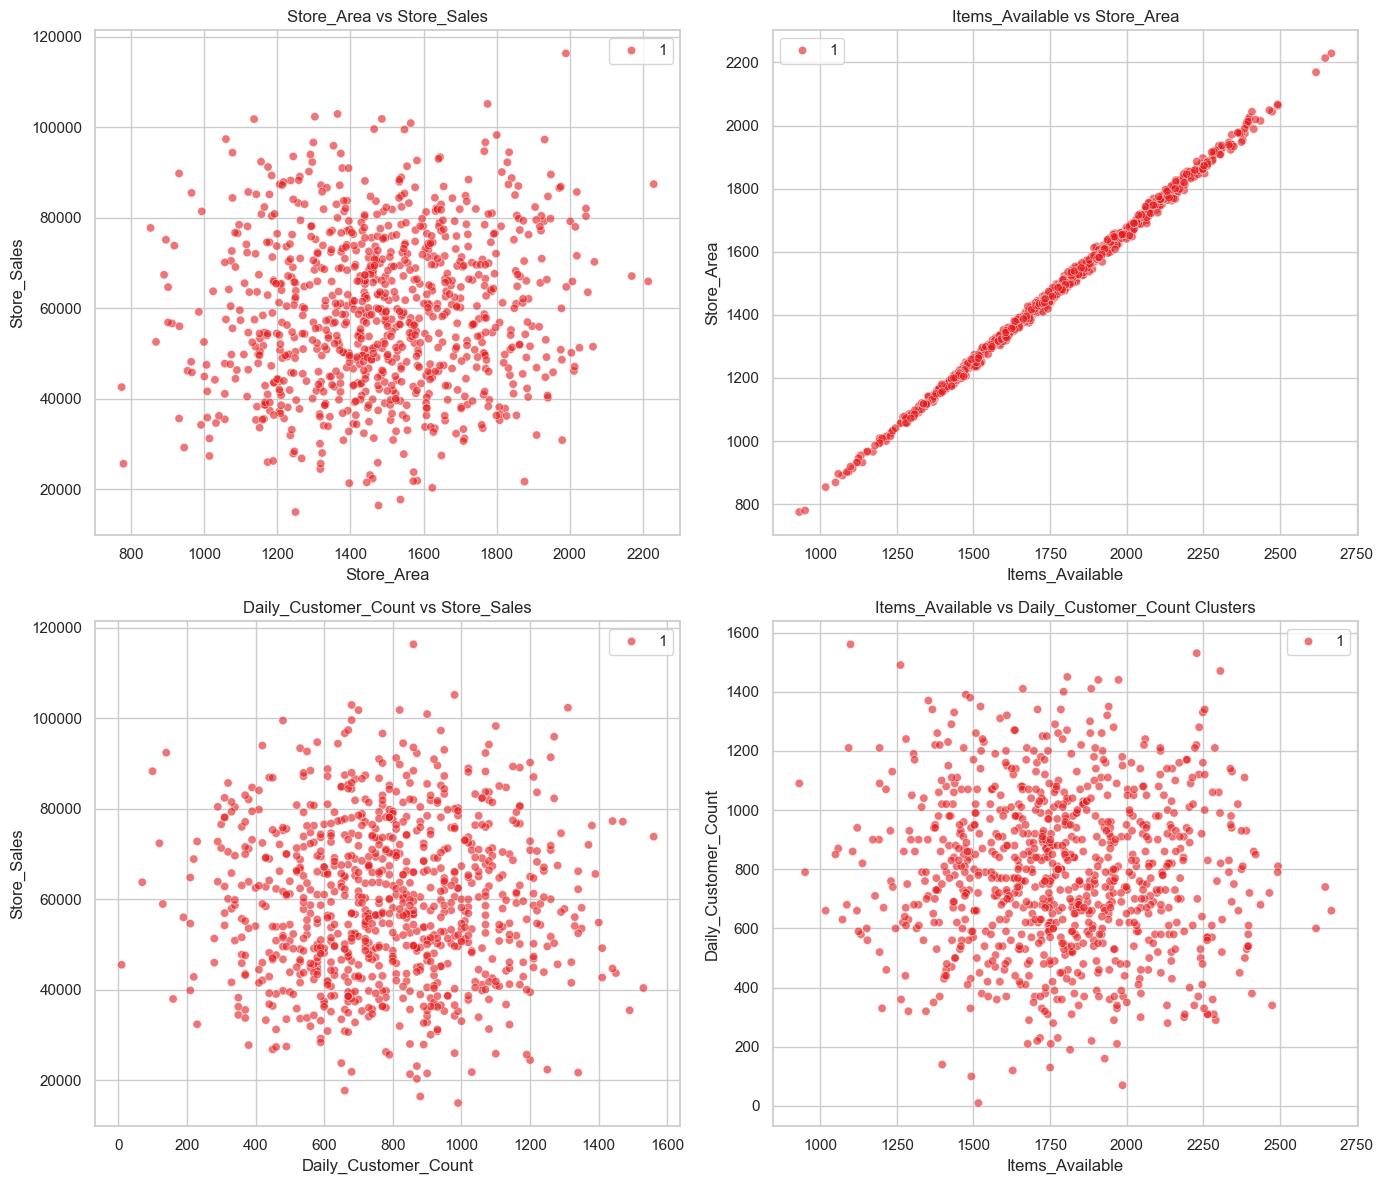

In [39]:
# Визуализация кластеров
plt.figure(figsize=(14, 12))

# Парный график 1: Store_Area vs Store_Sales
plt.subplot(2, 2, 1)
sns.scatterplot(
    x=df_cleaned["Store_Area"],
    y=df_cleaned["Store_Sales"],
    hue=result,
    palette="Set1",
    alpha=0.6,
)
plt.title("Store_Area vs Store_Sales")
plt.xlabel('Store_Area')
plt.ylabel("Store_Sales")

# Парный график 2: Items_Available vs Store_Area
plt.subplot(2, 2, 2)
sns.scatterplot(
    x=df_cleaned["Items_Available"],
    y=df_cleaned["Store_Area"],
    hue=result,
    palette="Set1",
    alpha=0.6,
)
plt.title("Items_Available vs Store_Area")
plt.xlabel("Items_Available")
plt.ylabel("Store_Area")

# Парный график 3: Daily_Customer_Count vs Store_Sales
plt.subplot(2, 2, 3)
sns.scatterplot(
    x=df_cleaned["Daily_Customer_Count"],
    y=df_cleaned["Store_Sales"],
    hue=result,
    palette="Set1",
    alpha=0.6,
)
plt.title("Daily_Customer_Count vs Store_Sales")
plt.xlabel("Daily_Customer_Count")
plt.ylabel("Store_Sales")

# Парный график 4: Items_Available vs Daily_Customer_Count
plt.subplot(2, 2, 4)
sns.scatterplot(
    x=df_cleaned["Items_Available"],
    y=df_cleaned["Daily_Customer_Count"],
    hue=result,
    palette="Set1",
    alpha=0.6,
)
plt.title("Items_Available vs Daily_Customer_Count Clusters")
plt.xlabel("Items_Available")
plt.ylabel("Daily_Customer_Count")

# Настройка графиков
plt.tight_layout()
plt.show()

## KMeans (неиерархическая кластеризация) для сравнения

Центры кластеров:
 [[ 1745.60833333  2093.9625       640.70833333 65702.91666667]
 [ 1334.08658009  1600.46320346   639.17748918 44322.25108225]
 [ 1590.27536232  1908.01449275  1048.26086957 55292.41545894]
 [ 1259.72477064  1511.40825688   853.94495413 72138.0733945 ]]


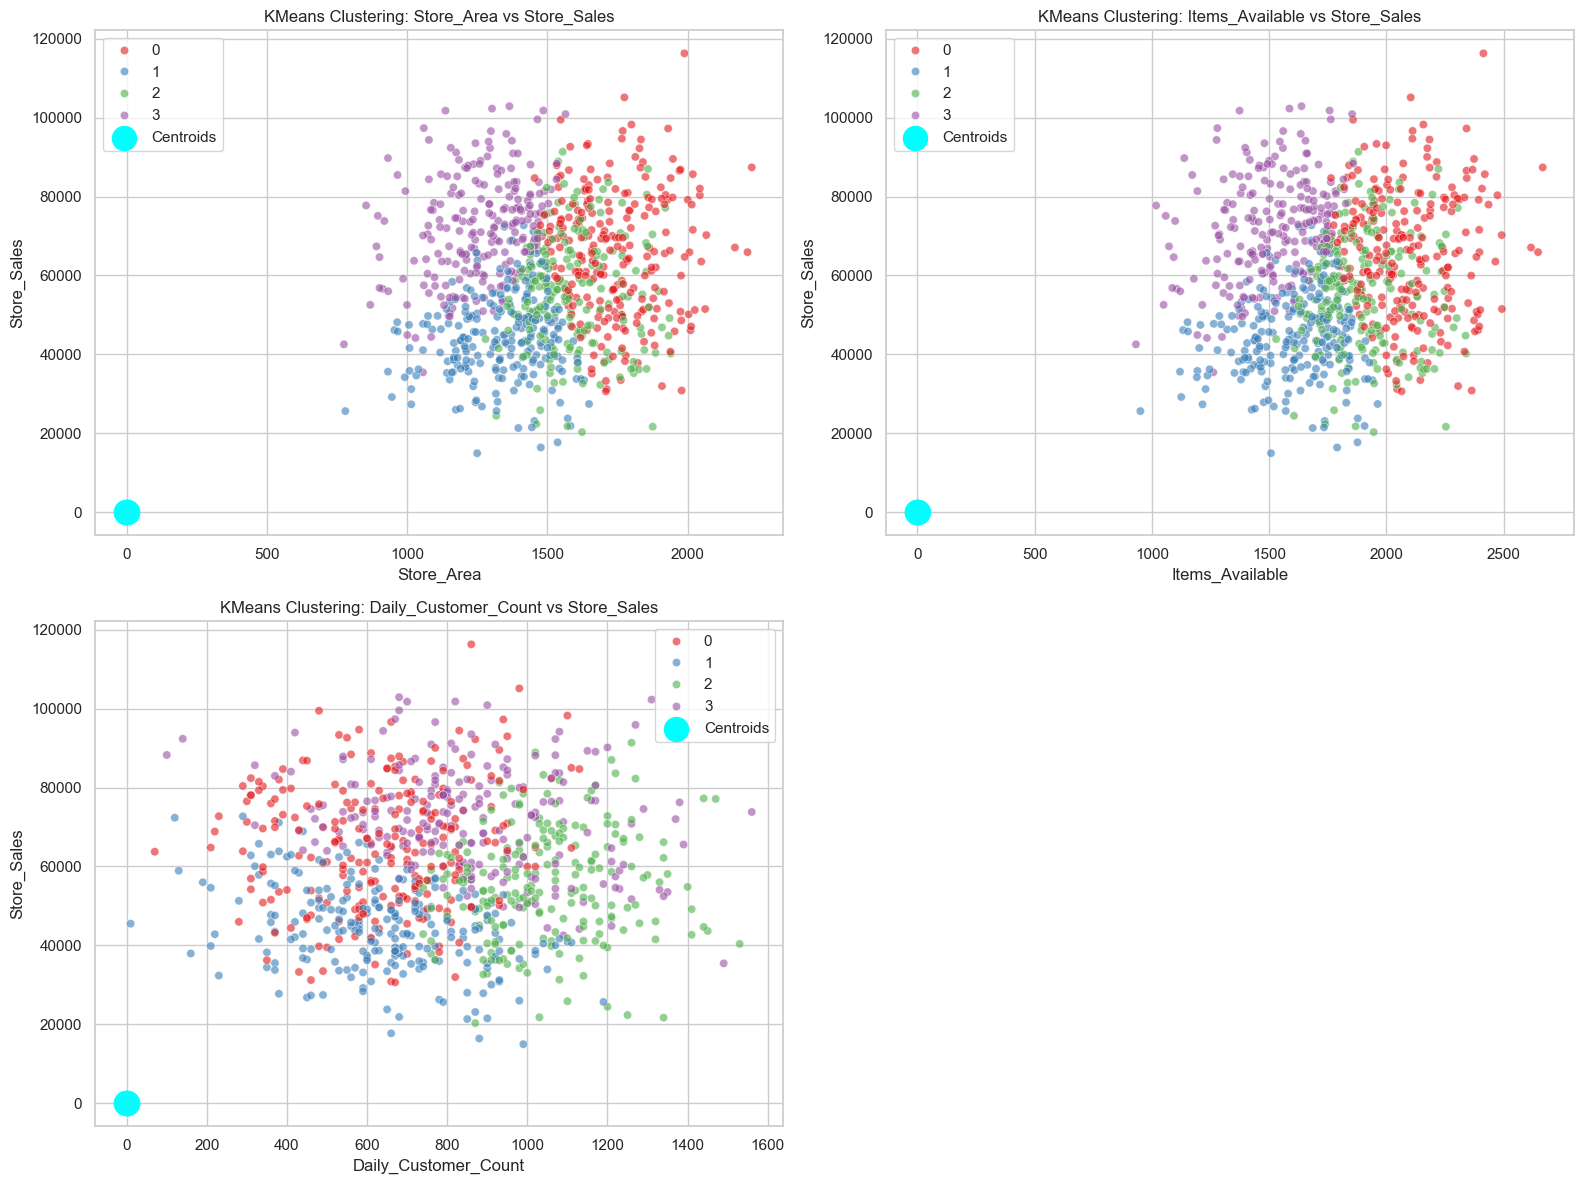

In [40]:
features_used = [
    "Store_Area",
    "Items_Available",
    "Daily_Customer_Count",
    "Store_Sales"
]
data_to_scale = df_cleaned[features_used]
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_to_scale)

random_state = 42
kmeans = KMeans(n_clusters=4, random_state=random_state)
labels = kmeans.fit_predict(data_scaled)
centers = kmeans.cluster_centers_

# Отображение центроидов
centers_original = scaler.inverse_transform(centers)  # Обратная стандартизация
print("Центры кластеров:\n", centers_original)

# Визуализация результатов кластеризации KMeans
plt.figure(figsize=(16, 12))
plt.subplot(2, 2, 1)
sns.scatterplot(
    x=df_cleaned["Store_Area"],
    y=df_cleaned["Store_Sales"],
    hue=labels,
    palette="Set1",
    alpha=0.6,
)
plt.scatter(centers[:, 0], centers[:, 1], s=300, c='cyan', label='Centroids')
plt.title("KMeans Clustering: Store_Area vs Store_Sales")
plt.legend()

plt.subplot(2, 2, 2)
sns.scatterplot(
    x=df_cleaned["Items_Available"],
    y=df_cleaned["Store_Sales"],
    hue=labels,
    palette="Set1",
    alpha=0.6,
)
plt.scatter(centers[:, 2], centers[:, 3], s=300, c='cyan', label='Centroids')
plt.title("KMeans Clustering: Items_Available vs Store_Sales")
plt.legend()

plt.subplot(2, 2, 3)
sns.scatterplot(
    x=df_cleaned["Daily_Customer_Count"],
    y=df_cleaned["Store_Sales"],
    hue=labels,
    palette="Set1",
    alpha=0.6,
)
plt.scatter(centers[:, 1], centers[:, 3], s=300, c='cyan', label='Centroids')
plt.title("KMeans Clustering: Daily_Customer_Count vs Store_Sales")
plt.legend()


plt.tight_layout()
plt.show()

### PCA для визуализации сокращенной размерности

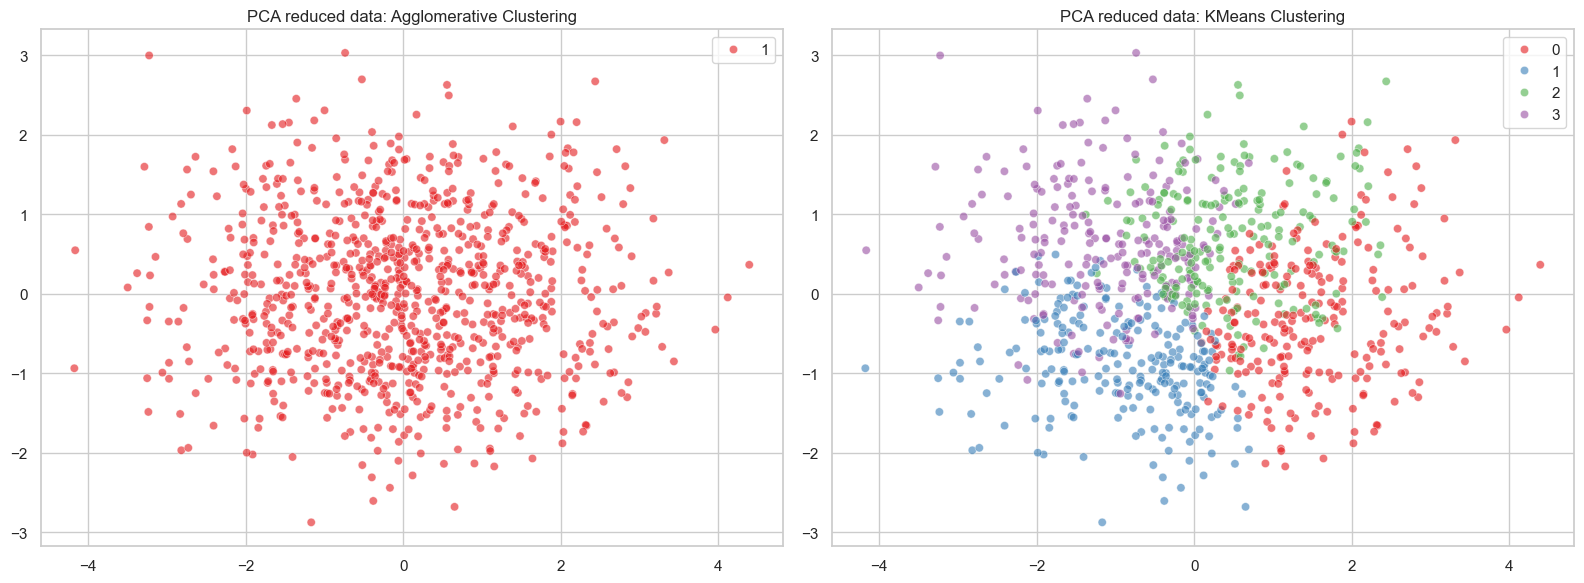

In [41]:
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(data_scaled)

# Визуализация сокращенных данных
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
sns.scatterplot(x=reduced_data[:, 0], y=reduced_data[:, 1], hue=result, palette='Set1', alpha=0.6)
plt.title('PCA reduced data: Agglomerative Clustering')

plt.subplot(1, 2, 2)
sns.scatterplot(x=reduced_data[:, 0], y=reduced_data[:, 1], hue=labels, palette='Set1', alpha=0.6)
plt.title('PCA reduced data: KMeans Clustering')

plt.tight_layout()
plt.show()

### Анализ инерции для метода локтя (метод оценки суммы квадратов расстояний)

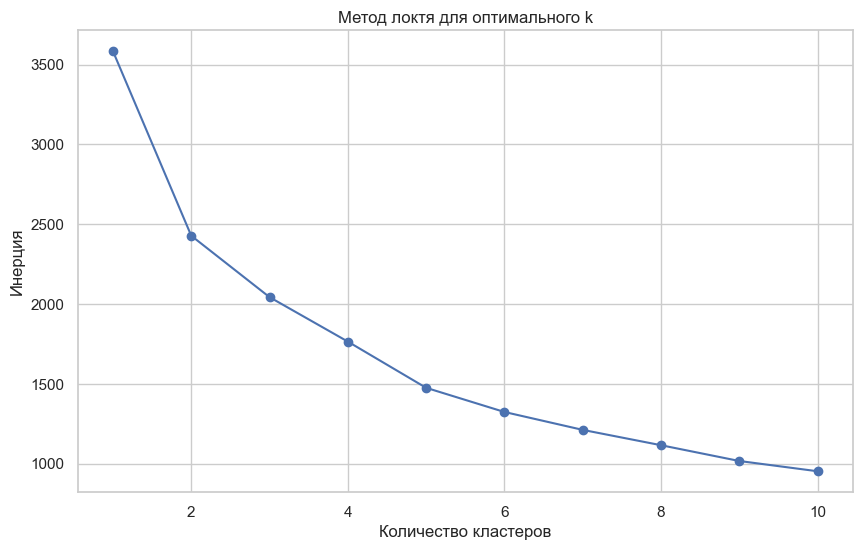

In [42]:
inertias = []
clusters_range = range(1, 11)
for i in clusters_range:
    kmeans = KMeans(n_clusters=i, random_state=random_state)
    kmeans.fit(data_scaled)
    inertias.append(kmeans.inertia_)


plt.figure(figsize=(10, 6))
plt.plot(clusters_range, inertias, marker='o')
plt.title('Метод локтя для оптимального k')
plt.xlabel('Количество кластеров')
plt.ylabel('Инерция')
plt.grid(True)
plt.show()

### Расчет коэффициентов силуэта

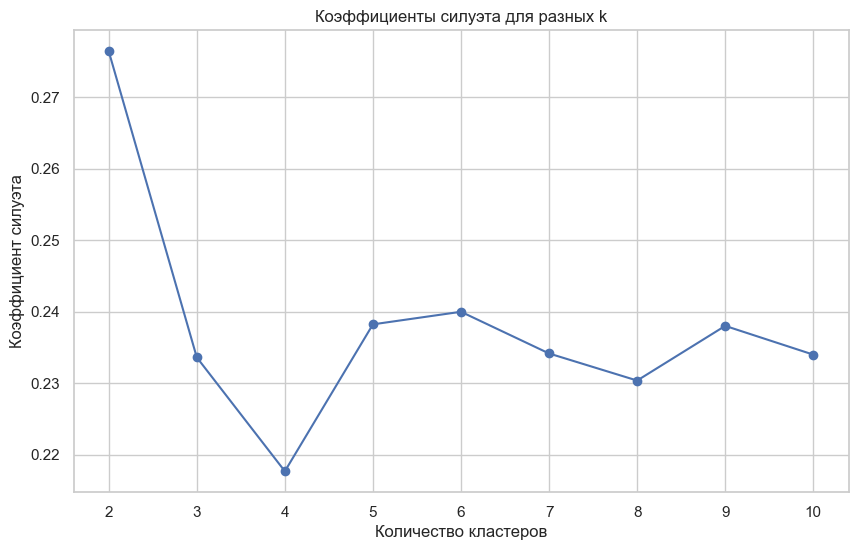

In [43]:
silhouette_scores = []
for i in clusters_range[1:]:  
    kmeans = KMeans(n_clusters=i, random_state=random_state)
    labels = kmeans.fit_predict(data_scaled)
    score = silhouette_score(data_scaled, labels)
    silhouette_scores.append(score)

# Построение диаграммы значений силуэта
plt.figure(figsize=(10, 6))
plt.plot(clusters_range[1:], silhouette_scores, marker='o')
plt.title('Коэффициенты силуэта для разных k')
plt.xlabel('Количество кластеров')
plt.ylabel('Коэффициент силуэта')
plt.grid(True)
plt.show()

Средний коэффициент силуэта: 0.234


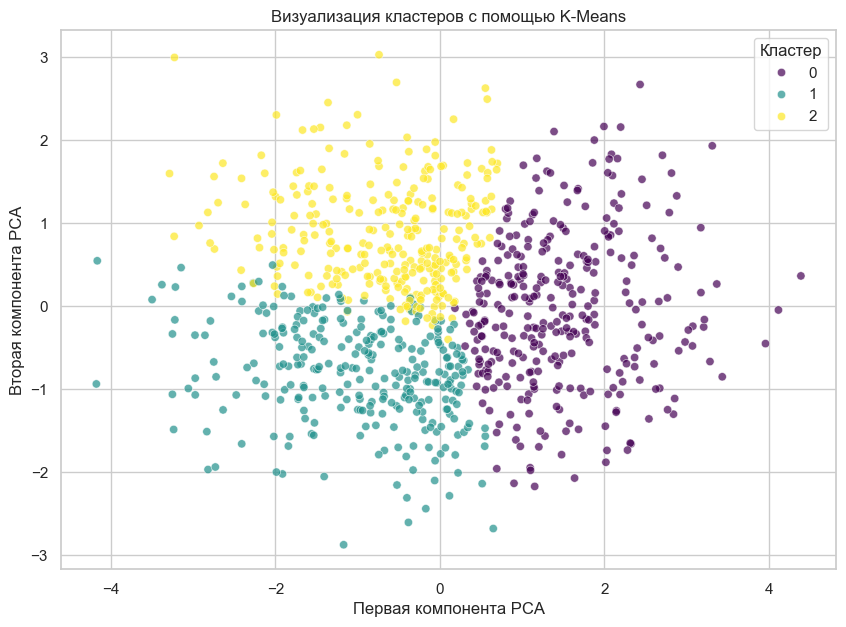

In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

# ========================
# Применение K-Means
# ========================
kmeans = KMeans(n_clusters=3, random_state=42)  
df_clusters = kmeans.fit_predict(df_scaled)

# ========================
# Оценка качества кластеризации
# ========================
silhouette_avg = silhouette_score(df_scaled, df_clusters)
print(f'Средний коэффициент силуэта: {silhouette_avg:.3f}')

# ========================
# Визуализация кластеров
# ========================
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
df_pca = pca.fit_transform(df_scaled)

plt.figure(figsize=(10, 7))
sns.scatterplot(x=df_pca[:, 0], y=df_pca[:, 1], hue=df_clusters, palette='viridis', alpha=0.7)
plt.title('Визуализация кластеров с помощью K-Means')
plt.xlabel('Первая компонентa PCA')
plt.ylabel('Вторая компонентa PCA')
plt.legend(title='Кластер', loc='upper right')
plt.show()

Средний коэффициент силуэта, равный 0.234, указывает на умеренно хорошую кластеризацию.  

Средний коэффициент силуэта (silhouette score) указывает на качество кластеризации, измеряя, насколько хорошо точки внутри одного кластера близки друг к другу по сравнению с точками из других кластеров. Значения коэффициента силуэта находятся в диапазоне от -1 до 1:

1: Указывает на идеально плотные и четко разделенные кластеры.  
0: Указывает на перекрытие кластеров или слабую структуру кластеризации.  
Отрицательные значения: Указывают, что точки в кластере расположены ближе к другому кластеру, чем к своему.

Средний коэффициент силуэта (агломеративная кластеризация): 0.199


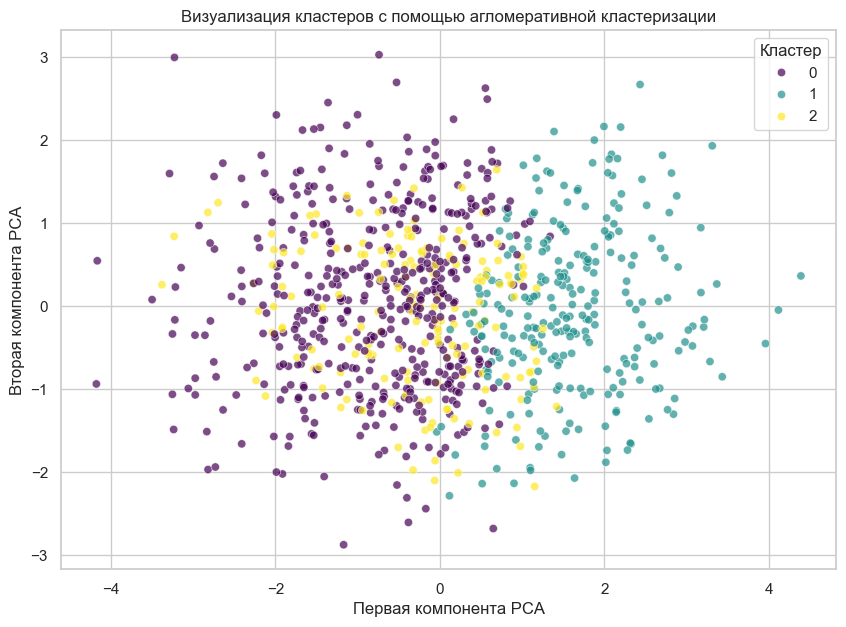

In [45]:
from sklearn.cluster import AgglomerativeClustering

# ========================
# Агломеративная кластеризация
# ========================
agg_cluster = AgglomerativeClustering(n_clusters=3)  
labels_agg = agg_cluster.fit_predict(df_scaled)

# ========================
# Оценка качества кластеризации
# ========================
silhouette_avg_agg = silhouette_score(df_scaled, labels_agg)
print(f'Средний коэффициент силуэта (агломеративная кластеризация): {silhouette_avg_agg:.3f}')

# ========================
# Визуализация кластеров
# ========================
pca = PCA(n_components=2)
df_pca = pca.fit_transform(df_scaled)

plt.figure(figsize=(10, 7))
sns.scatterplot(x=df_pca[:, 0], y=df_pca[:, 1], hue=labels_agg, palette='viridis', alpha=0.7)
plt.title('Визуализация кластеров с помощью агломеративной кластеризации')
plt.xlabel('Первая компонентa PCA')
plt.ylabel('Вторая компонентa PCA')
plt.legend(title='Кластер', loc='upper right')
plt.show()

Значение коэффициента силуэта лежит в диапазоне от -1 до 1. Ближе к 1: Хорошо сформированные, плотные кластеры, четко отделенные друг от друга.  

Ближе к 0: Кластеры пересекаются или слабо разделены, не имеют четких границ. Точки расположены одинаково близко как к своему кластеру, так и к соседним. 
Ближе к -1 (Отрицательные значения): Некоторые точки скорее относятся к другим кластерам, чем к текущему (ближе к центрам других кластеров). Очень плохая кластеризация.  
Ближе к 1: Все точки внутри каждого кластера плотно сгруппированы и значительно удалены от точек других кластеров. Свидетельствует о четкой и хорошо разделенной структуре данных. Единица говорит об идеальной кластеризации.

Значение 0.199 указывает на то, что кластеры с нечеткой границей и неоптимальный выбор числа кластеров или особенности данных, затрудняющие их разделение.